In [1]:
import libs.forward_model as fm
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import scipy.io

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Generate the forward model

In [16]:
# Parameter Definition
NA = 1.2
Rindex = 1.5
lambda_ = 532.0/1000 #um
dx, dy, dz = 1/3, 1/3, 1 #um
ep_dx, ep_dy = 2, 2 #um

Nx,Ny,Nz = 32, 32, 5
m = 3

down_factor = .5
num_planes = 2

fm.init_parameters(NA_=NA, Rindex_=Rindex, lambda_=lambda_, dx_=dx, dy_=dy, dz_=dz, Nx_=Nx, Ny_=Ny, Nz_=Nz)
fm.init_DMD_patterns(m, ep_dx__=ep_dx, ep_dy__=ep_dy)
fm.init_one_shot(m, down_factor=down_factor, num_planes=num_planes)

A = fm.A
print(f"Shape of matrix A: {A.shape}")

Sucessfully Initialized Point Spread Function...!!!
Matrix A is intialized sucessfully...!!!
Shape of matrix A: torch.Size([1536, 5120])


Save the forward model

In [17]:
description = "NA=1.2, Rindex=1.5, dx,dy,dz=1/3,1/3,1, ep_dx,ep_dy=2,2"

data_dict = {
    'forward_matrix': fm.A,
    'description': description,
    'Nx': Nx,
    'Ny': Ny,
    'Nz': Nz,
    'm': m,
    'df': down_factor,
    'np': num_planes,
}

file_path = 'A_nz5_np2_m3.pth'
torch.save(data_dict, file_path)

Load a forward model

In [38]:
file_path = 'A_nz11_np2_m6.pth'
loaded_data = torch.load(file_path)

A = loaded_data['forward_matrix']
Nx = loaded_data['Nx']
Ny = loaded_data['Ny']
Nz = loaded_data['Nz']
m = loaded_data['m']
down_factor = loaded_data['df']
num_planes = loaded_data['np']

print(loaded_data['description'])
print(A.shape)
print('Nz Ny Nz = ', Nx,Ny,Nz)
print('m =', m)
print('df =', down_factor)
print('np =', num_planes)


NA=1.2, Rindex=1.5, dx,dy,dz=1/3,1/3,1, ep_dx,ep_dy=2,2
torch.Size([3072, 11264])
Nz Ny Nz =  32 32 11
m = 6
df = 0.5
np = 1


#### Generate data for reconstruction

$$
\text{argmin}_x \left( \frac{1}{2} \lVert y - Ax \rVert^2 + \lambda \phi(x) \right)
$$

In [30]:
def one_shot_model(X):
    return torch.matmul(A,X)

def add_gaussian_noise(signal, snr_dB):
    signal_power = torch.mean(signal**2)
    snr = 10**(snr_dB / 10.0)
    noise_power = signal_power / snr
    noise = torch.randn_like(signal) * torch.sqrt(noise_power)
    noisy_signal = signal + noise
    return noisy_signal

Load the object

Sucessfully Initialized Read Data Parameters...!!!
Object Loaded Sucessfully...!!!


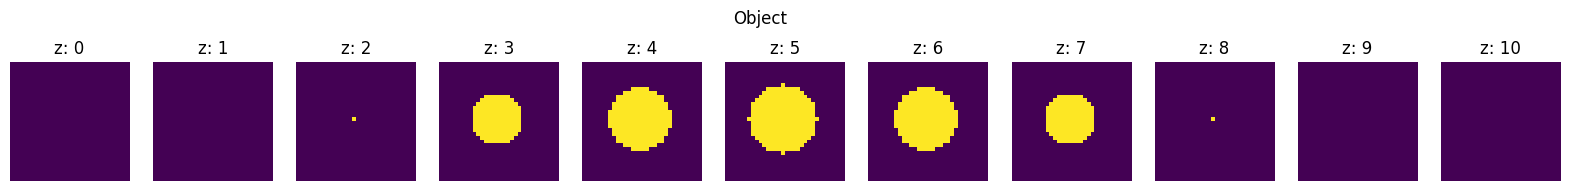

In [42]:
import libs.read_data as rd
rd.init_parameters(Nx,Ny,Nz,dx,dy,dz)

rd.load_object("3D_sphere", verbose=True, radius = 3) 
X_original = (rd.X).flatten()

X3D_orig = X_original.view(Nz,Nx,Ny)
fm.show_planes_z(X3D_orig.detach().cpu().numpy(), 'Object', [i for i in range(Nz)])


Image the object

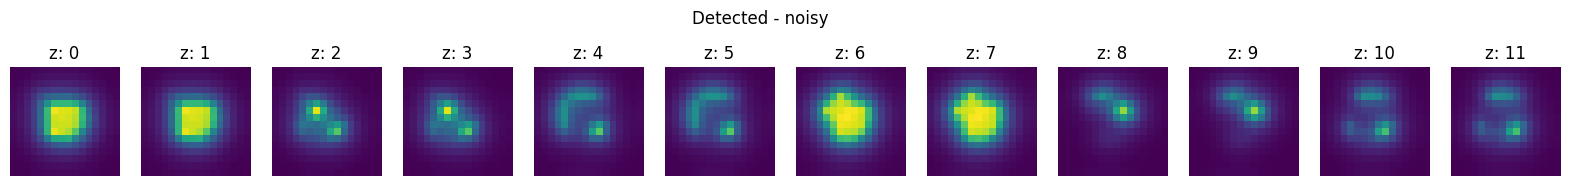

In [43]:
Y = one_shot_model(X_original)

desired_snr_dB = 10.0
# Y_noisy = add_gaussian_noise(Y, desired_snr_dB)
Y_noisy = Y

NxY, NyY = int(Nx*down_factor), int(Ny*down_factor)
Y3D = Y.view(m*num_planes, NxY, NyY)
Y3D_noisy = Y_noisy.view(m*num_planes, NxY, NyY)

# fm.show_planes_z(Y3D.detach().cpu().numpy(), "Detected - noisless", [i for i in range(m*num_planes)])
fm.show_planes_z(Y3D_noisy.detach().cpu().numpy(), "Detected - noisy", [i for i in range(m*num_planes)])

Save the data

In [83]:
# Convert Torch tensors to NumPy arrays
A_np = A.numpy()
X_original_np = X_original.numpy()
Y_np = Y.numpy()
Yn_np = Y_noisy.numpy()

# Create a dictionary to store the matrices with appropriate variable names
mat_dict = {'A': A_np, 'X_original': X_original_np, 'Y': Y_np, 'Yn': Yn_np}

# Save the dictionary to a .mat file
scipy.io.savemat('NC_m3_np2_df0.5_32x32x5.mat', mat_dict)


lstsq reconstruction

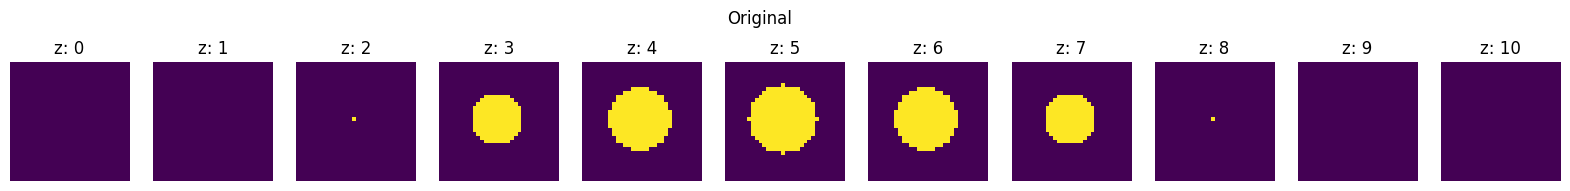

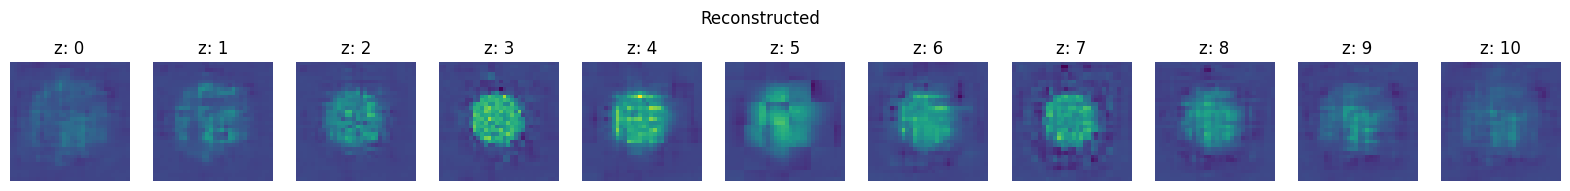

In [44]:
X_reconstructed = torch.linalg.lstsq(A, Y_noisy).solution   
X3D_recons = X_reconstructed.view(Nz, Nx, Ny)

fm.show_planes_z(X3D_orig.detach().cpu().numpy(), "Original", [i for i in range(Nz)])
fm.show_planes_z(X3D_recons.detach().cpu().numpy(), "Reconstructed", [i for i in range(Nz)])

Rank check

In [17]:
ATA = (A.T@A).float()
print("Conditional Number: ","{:.4e}".format(torch.linalg.cond(ATA)))
print(f"Rank : {torch.linalg.matrix_rank(ATA)}")
print(f"Pixels to reconstruct : {Nx*Ny*Nz}")

Conditional Number:  4.2614e+12
Rank : 480
Pixels to reconstruct : 11264
